In [1]:
import pandas as pd
from google.cloud import bigquery
import numpy as np
import pickle
import gpflow
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary
import download_airnow_web
import pyproj
%matplotlib inline
from paper_utils import *

usecache = True

/home/mike/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
if usecache is False:
    airqodf = loaddata("/home/mike/.gcp_keys/AirQo-519978d8cadc.json")
    embassydf = download_airnow_web.download('Kampala')
    df = combinedatasets(airqodf,embassydf)
    pickle.dump(df,open('alldataprocessed.p','wb'))
else:
    df = pickle.load(open('alldataprocessed.p','rb'))
    
box = 30
lcs = df[(df['channel_id']==832251) & (np.abs(df['x']-3628185)<box) & (np.abs(df['y']-33321)<box)]
ems = df[df['channel_id']==-1]
ems = ems[ems['pm2_5']>=0]
ems = ems[ems['created_at']>('2019-07-25')]
resampledlcs = lcs.resample('H',on='created_at').mean().dropna()
mergeddf = pd.merge(resampledlcs,ems,on='created_at')

In [3]:
X=np.array([x.timestamp() for x in mergeddf['created_at'].to_numpy()])[:,None]/(3600)
#X = X-np.min(X)
Y=(mergeddf['pm2_5_x']/mergeddf['pm2_5_y']).to_numpy()
Y[Y>4]=4
keep = ~np.isnan(Y)
mergeddf = mergeddf[keep]
indexes = mergeddf['created_at']
X = X[keep,:]
Y = Y[keep]
Y = np.log(Y[:,None])

In [4]:
import GPy
k = GPy.kern.RBF(1,lengthscale=(24*10.0))+GPy.kern.Bias(1,10)
lockdown = pd.datetime(2020,3,18).timestamp()/3600
Xbefore = X[X[:,0]<lockdown,:]
Ybefore = Y[X[:,0]<lockdown,:]
Xafter = X[X[:,0]>=lockdown,:]
Yafter = Y[X[:,0]>=lockdown,:]

mbefore = GPy.models.GPRegression(Xbefore[:,:],Ybefore[:,:],k)
mafter = GPy.models.GPRegression(Xafter[:,:],Yafter[:,:],k)

 /home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning:The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


In [5]:
import datetime
Xtest = np.linspace(np.min(X),np.max(X),100)[:,None]
preds_mus,preds_vars = mbefore.predict_noiseless(Xtest)
preds_mus[Xtest[:,0]>lockdown,:],_ = mafter.predict_noiseless(Xtest[Xtest[:,0]>lockdown])
testindexes = [datetime.datetime.utcfromtimestamp(xt*3600) for xt in Xtest]

In [6]:

def drawplot(start,end,delta,spaces,markersize=3):
    steps = (end-start).days
    plt.scatter(indexes,mergeddf['pm2_5_x'],markersize,'b',label='PMS')
    plt.scatter(indexes,mergeddf['pm2_5_y'],markersize,'r',label='Embassy')
    plt.vlines(pd.datetime(2020,3,18),0,200)
    plt.grid()
    plt.ylim([0,200])
    plt.xlim(start,end)
  
    dates,strings = getdatelist(start,delta,int(steps/delta.days),spaces)
  
    if delta.days<30:
        plt.xticks(dates,strings)
    plt.legend()
    plt.ylabel('PM2.5 / $\mu g/m^3$')

 /home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning:The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
 /home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning:The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
 /home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
 /home/mike/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning:The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
 /home/mike/Documents/Research/calibration/jupyter/paper_utils.py:146: FutureWarning:The pandas.datetime class is deprecated and will be removed from p

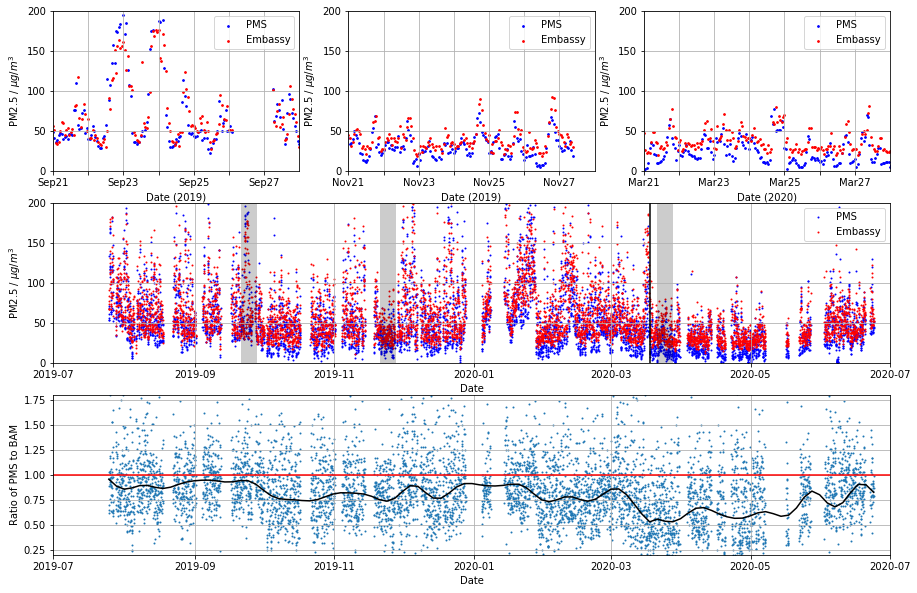

In [7]:
from matplotlib.gridspec import GridSpec
fig=plt.figure(figsize=[15,10])
gs = GridSpec(3, 3, figure=fig)
segstart = [pd.datetime(2019,9,21),pd.datetime(2019,11,21),pd.datetime(2020,3,21)]
segend = [pd.datetime(2019,9,28),pd.datetime(2019,11,28),pd.datetime(2020,3,28)]

ax = fig.add_subplot(gs[0, 0])
drawplot(segstart[0],segend[0],pd.Timedelta(1,'day'),2)
plt.xlabel('Date (2019)')
ax = fig.add_subplot(gs[0, 1])
drawplot(segstart[1],segend[1],pd.Timedelta(1,'day'),2)
plt.xlabel('Date (2019)')
ax = fig.add_subplot(gs[0, 2])
drawplot(segstart[2],segend[2],pd.Timedelta(1,'day'),2)
plt.xlabel('Date (2020)')

ax1 = fig.add_subplot(gs[1, :])
drawplot(pd.datetime(2019,7,1),pd.datetime(2020,7,1),pd.Timedelta(30,'day'),2,markersize=1)
plt.xlabel('Date')
for i in range(3):
    plt.fill([segstart[i],segend[i],segend[i],segstart[i]],[0,0,200,200],'k',alpha=0.2)

ax1 = fig.add_subplot(gs[2, :])
#plt.subplot(2,1,2)
plt.scatter(indexes,np.exp(Y),1,alpha=1,label='PMS/Embassy')
plt.plot_date(testindexes,np.exp(preds_mus),'-k')#,1,c='k')
#plt.plot_date(testindexes,preds_mus-2*np.sqrt(preds_vars),'k-',alpha=0.5)
#plt.plot_date(testindexes,preds_mus+2*np.sqrt(preds_vars),'k-',alpha=0.5)
plt.grid()
plt.hlines(1,pd.datetime(2019,7,1),pd.datetime(2020,7,1),'r')
plt.xlim(pd.datetime(2019,7,1),pd.datetime(2020,7,1))
plt.xlabel('Date')
plt.ylim([0.2,1.8])
plt.ylabel('Ratio of PMS to BAM')
#plt.legend()
#plt.yscale('log')
plt.savefig('embassy_ratio.pdf')

In [8]:
from scipy import optimize
x = np.array([1,2,3,4,5.0])
y = np.array([0,1.1,1.9,3.3,5.0])
def fn(x,m,c):
    return m*x + c
def fn2ndorder(x,b,m,c):
    return b*x**2 + m*x + c
#popt, pcov = optimize.curve_fit(fn,x,y)
#popt,np.sqrt(np.diag(pcov))

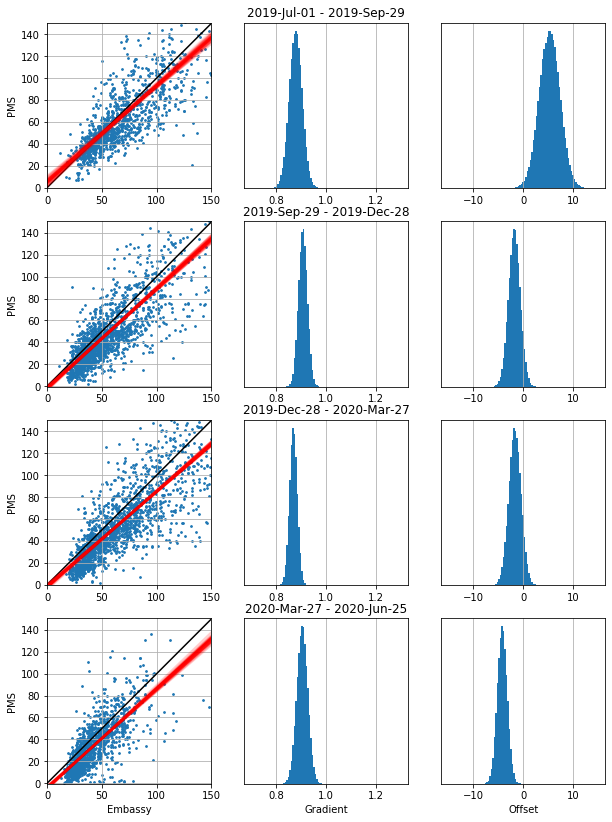

In [9]:
plt.figure(figsize=[10,14])
t = pd.Timestamp('2019-07-01',tz='utc')
indx=1
for i in range(20):
    
    #print(t)
    keep = (mergeddf['created_at']>t)  & (mergeddf['created_at']<t+pd.Timedelta(90,'day'))
    if sum(keep)==0: continue
    
    xs = mergeddf['pm2_5_y'][keep].to_numpy()
    ys = mergeddf['pm2_5_x'][keep].to_numpy()
    ys = ys[xs>=5]
    xs = xs[xs>=5]

    sigma = ys/3
    #sigma[sigma<1]=1
    popt, pcov = optimize.curve_fit(fn,xs,ys)#,sigma=sigma)
    ##popt, pcov = optimize.curve_fit(fn2ndorder,xs,ys,sigma=sigma)
    
    
    plt.subplot(4,3,indx)
    
    
    plt.scatter(xs,ys,3,alpha=1)
    plt.grid()
    plt.axis('equal')
    
    plt.xlim([0,150])
    plt.ylim([0,150])
    plt.ylabel('PMS')
    if indx==10: plt.xlabel('Embassy')
    
    xvals = np.linspace(0,150,30)
    plt.plot([0,150],[0,150],'k-')
    for m,c in np.random.multivariate_normal(popt,pcov,100):
    ##for b,m,c in np.random.multivariate_normal(popt,pcov,100):
        plt.plot(xvals,fn(xvals,m,c),'r-',alpha=0.1)
        ##plt.plot(xvals,fn2ndorder(xvals,b,m,c),'k-',alpha=0.1)
    plt.subplot(4,3,indx+1)
    #from scipy.stats import multivariate_normal as mnorm
    ms = []
    cs = []
    bs = []
    for m,c in np.random.multivariate_normal(popt,pcov,100000):
    ##for b,m,c in np.random.multivariate_normal(popt,pcov,100000):
        #v.append(fn(0,a,m,c))
        ms.append(m)#+b*25)
        cs.append(c)
    plt.hist(ms,np.linspace(0.7,1.3,100))
    if indx==10: plt.xlabel('Gradient')
    plt.title("%s - %s" % (t.strftime('%Y-%b-%d'),(t+pd.Timedelta(90,'day')).strftime('%Y-%b-%d')))
    plt.yticks([])
    plt.grid()
    plt.subplot(4,3,indx+2)
    plt.hist(cs,np.linspace(-15,15,100))
    plt.yticks([])
    plt.grid()
    if indx==10: plt.xlabel('Offset')
    t = t + pd.Timedelta(90,'day')
    indx+=3
plt.savefig('embassydemo.pdf')

In [10]:
resampledlcs['created_at'] = resampledlcs.index

In [11]:
combineddf = pd.concat([resampledlcs,ems])
encounters = build_encounters(combineddf)

1 of 2 (6254 encounters recorded)
2 of 2 (6254 encounters recorded)


In [12]:
newid = {}
for i,unq in enumerate(pd.concat([encounters['channel_id_sensorA'],encounters['channel_id_sensorB']]).unique()):
    newid[unq] = i

In [13]:
newid[832251]=1
newid[-1]=0

In [14]:

X = []
Y = []
for idx,enc in encounters.iterrows():
    dt = enc['created_at_2_sensorB']+(enc['created_at_2_sensorB']-enc['created_at_2_sensorA'])/2
    X.append([dt.timestamp()/3600,newid[enc['channel_id_sensorA']],newid[enc['channel_id_sensorB']]])
    Y.append([enc['pm2_5_sensorA'],enc['pm2_5_sensorB']])
X = np.array(X)
Y = np.array(Y)
Z = np.linspace(min(X[:,0]),max(X[:,0]),50)[:,None]
refsensor = np.array([1,0])

In [15]:
#remove outliers.
keep = (Y[:,0]<200) & (Y[:,0]>5) & (Y[:,1]<200) & (Y[:,1]>5)
X = X[keep,:]
Y = Y[keep,:]

In [16]:
#Y[:,1]=Y[:,0]+np.random.randn(len(Y))
#Y[:,1]=Y[:,1]*np.linspace(0.1,1,len(Y))

In [17]:
from calibration import placeinducingpoints, CalibrationSystem, CalibrationSystemNoMiniBatch, EQ, SparseModel, Kernel, getcov
import tensorflow as tf

def transform_fn(samps,Y,sideY):
    return Y*tf.exp(samps[:,:,0:1])+10*samps[:,:,1:2] 

k = gpflow.kernels.RBF(10,24*180)+gpflow.kernels.Bias(10)
klike = gpflow.kernels.RBF(10,24*180)+gpflow.kernels.Bias(10)
#cs = CalibrationSystem(X, Y, Z, refsensor, 2, transform_fn, k,likelihoodstd=20.0,lr=0.005,minibatchsize=200,jitter=1e-3)
cs = CalibrationSystem(X, Y, Z, refsensor, 2, transform_fn, k,likemodel='distribution',gpflowkernellike=klike,lr=0.005,minibatchsize=200,jitter=2e-2)

import time
st = time.time()
elbo_record = cs.run(its=600)
print(time.time()-st)

W0804 12:07:10.944717 140255228761856 deprecation.py:323] From /home/mike/anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/distributions/distribution.py:284: MultivariateNormalFullCovariance.__init__ (from tensorflow_probability.python.distributions.mvn_full_covariance) is deprecated and will be removed after 2019-12-01.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


Starting Run
20 (ELBO=575329.6250)
40 (ELBO=351330.2812)
60 (ELBO=384153.4688)
80 (ELBO=372696.4375)
100 (ELBO=296741.9688)
120 (ELBO=273099.3750)
140 (ELBO=234247.1875)
160 (ELBO=219826.3594)
180 (ELBO=204127.7500)
200 (ELBO=172062.3906)
220 (ELBO=114191.8125)
240 (ELBO=143631.0469)
260 (ELBO=124730.4375)
280 (ELBO=126701.7500)
300 (ELBO=81585.6641)
320 (ELBO=102932.7188)
340 (ELBO=116083.7344)
360 (ELBO=90137.7266)
380 (ELBO=94690.2969)
400 (ELBO=104238.7266)
420 (ELBO=94605.6406)
440 (ELBO=67129.4688)
460 (ELBO=91556.1953)
480 (ELBO=67213.2500)
500 (ELBO=63654.3750)
520 (ELBO=57497.9102)
540 (ELBO=57085.7734)
560 (ELBO=57320.8633)
580 (ELBO=69589.9062)
600 (ELBO=48549.9492)
107.64653825759888


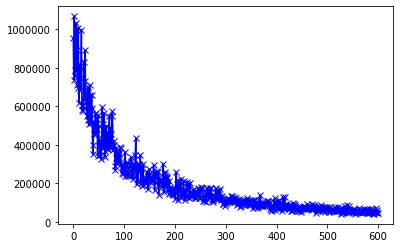

In [18]:
plt.plot(elbo_record,'b-x')
#plt.ylim([30000,40000]) #40=>14642, 20=>13

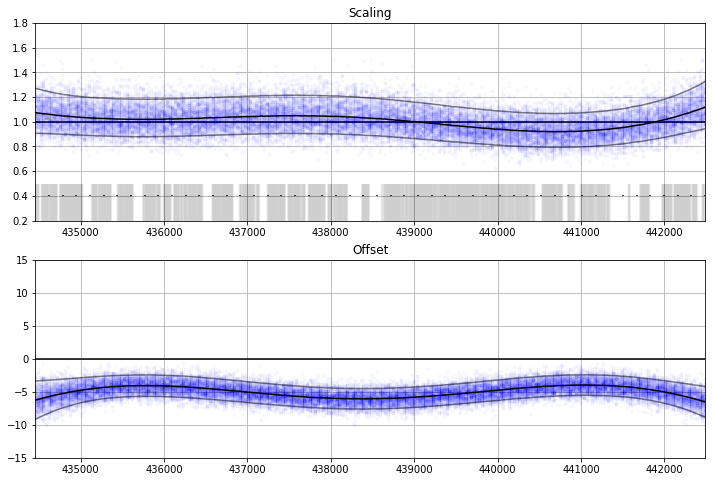

In [19]:
#build test matrix
C = 2
Nsamps = 250 #151

for si,refs in enumerate(refsensor):
    if refs: continue
    x = np.linspace(min(X[:,0]),max(X[:,0]),Nsamps)
    testX = np.zeros([0,3])
    for ci in range(C):
        tempX = np.c_[x,np.ones_like(x)*si,np.full_like(x,ci)]
        testX = np.r_[testX,tempX]#.astype(int)
    testsm = SparseModel(testX,cs.Z,C,Kernel(k),jitter=5e-3)
    
    qf_mu,qf_cov = testsm.get_qf(cs.mu,cs.scale)
    samps = testsm.get_samples_one_sensor(cs.mu,cs.scale)
    
    #if cs.mulike is not None:
    #    qf_mulike,qf_covlike = testsm.get_qf(cs.mulike,cs.scalelike)
    #    sampslike = testsm.get_samples_one_sensor(cs.mulike,cs.scalelike)
    plt.figure(figsize=[12,8])
    
    for ci in range(C):
        plt.subplot(2,1,ci+1)
        if ci==1:
            plt.plot(x,-(10*samps[:,:,1].numpy().T),'b.',alpha=0.025);
            plt.ylim([-15,15])
            plt.plot(x,-10*qf_mu[Nsamps:,0],'k-')
            plt.plot(x,-10*((qf_mu[Nsamps:,0]-2*np.sqrt(np.diag(qf_cov)[Nsamps:]))),'k-',alpha=0.5)
            plt.plot(x,-10*((qf_mu[Nsamps:,0]+2*np.sqrt(np.diag(qf_cov)[Nsamps:]))),'k-',alpha=0.5)
            plt.hlines(0,np.min(X[:,0]),np.max(X[:,0]))
            plt.title('Offset')
        if ci==0:
            plt.plot(x,1/tf.exp(samps[:,:,0].numpy().T),'b.',alpha=0.025);
    
            plt.vlines(X[:,0],0,0.5,'k',alpha=0.01)
            #plt.plot(x,1/np.exp((qf_mu[:151,0]-2*np.sqrt(np.diag(qf_cov)[:151]))-2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0])),'k--',alpha=0.5)
            #plt.plot(x,1/np.exp((qf_mu[:151,0]+2*np.sqrt(np.diag(qf_cov)[:151]))+2*np.sqrt(np.exp(qf_mulike[:151,0]))/np.mean(Y[:,0])),'k--',alpha=0.5)
            plt.plot(x,1/np.exp((qf_mu[:Nsamps,0])),'k-')
            plt.plot(x,1/np.exp((qf_mu[:Nsamps,0]-2*np.sqrt(np.diag(qf_cov)[:Nsamps]))),'k-',alpha=0.5)
            plt.plot(x,1/np.exp((qf_mu[:Nsamps,0]+2*np.sqrt(np.diag(qf_cov)[:Nsamps]))),'k-',alpha=0.5)
            #plt.plot(X[:,0],Y[:,0]/Y[:,1],'xk',alpha=0.1,markersize=3)
            plt.ylim([0.2,1.8])
            plt.hlines(1,np.min(X[:,0]),np.max(X[:,0]))
            plt.title('Scaling')
        plt.xlim(np.min(X[:,0]),np.max(X[:,0]))
        plt.grid()
        plt.vlines(Z[:,0],.4,.41)

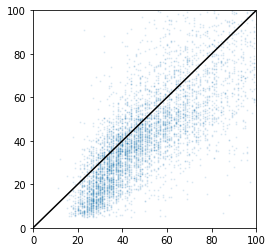

In [20]:
plt.figure(figsize=[4,4])
plt.scatter(Y[:,1],Y[:,0],1,alpha=0.1)
plt.xlim([0,100])
plt.ylim([0,100])
plt.plot([0,100],[0,100],'k-')

In [21]:
popt, pcov = optimize.curve_fit(fn,Y[:,1],Y[:,0])

In [22]:
popt

array([ 0.87095271, -0.55744642])

In [23]:
pcov

array([[ 6.23419707e-05, -3.64198303e-03],
       [-3.64198303e-03,  2.75287875e-01]])

In [ ]:
encounters = build_encounters(df)
pickle.dump(encounters,open('encounters.p','wb'))